In [1]:
import numpy as np
import pandas as pd
import sqlalchemy as sa

In [2]:
from dask import dataframe as dd 
from dask import array as da
from dask.diagnostics import ProgressBar # type: ignore

In [3]:
# read h5
embeddings = dd.read_hdf('embeddings.h5', key='embeddings', mode='r', chunksize=1000)

# load 10'000
# embeddings = embeddings.head(10000)

In [4]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.202381,0.087937,0.221610,0.171785,-0.782774,-0.325774,0.120273,0.625501,-0.072252,0.004225,...,0.421689,-0.342691,0.289151,-0.748062,-0.896266,0.605513,0.282313,0.264579,0.758309,0.718300
1,-0.202381,0.087936,0.221610,0.171785,-0.782773,-0.325774,0.120273,0.625501,-0.072252,0.004225,...,0.421690,-0.342690,0.289151,-0.748062,-0.896267,0.605513,0.282313,0.264579,0.758308,0.718299
2,-0.202380,0.087936,0.221610,0.171785,-0.782774,-0.325774,0.120273,0.625501,-0.072252,0.004225,...,0.421690,-0.342690,0.289151,-0.748062,-0.896267,0.605513,0.282313,0.264579,0.758308,0.718299
3,-0.202380,0.087936,0.221610,0.171785,-0.782773,-0.325774,0.120273,0.625501,-0.072252,0.004225,...,0.421690,-0.342690,0.289151,-0.748062,-0.896266,0.605513,0.282313,0.264579,0.758308,0.718299
4,-0.202380,0.087936,0.221611,0.171787,-0.782776,-0.325774,0.120273,0.625500,-0.072251,0.004225,...,0.421690,-0.342691,0.289150,-0.748062,-0.896269,0.605514,0.282313,0.264579,0.758308,0.718300


In [5]:
embeddings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
npartitions=552,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,floa

In [6]:
embeddings.shape

(<dask_expr.expr.Scalar: expr=FromGraph(4429402).size() // 768, dtype=int64>,
 768)

In [13]:
from torch import nn
import torch
device = torch.device("cuda")

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)
        
        return mean, log_var

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        
        x_hat = self.FC_output(h)
        return x_hat
        

In [15]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# Convert Dask DataFrame to NumPy array
embeddings_np = embeddings.compute().values

# Convert NumPy array to PyTorch tensor
embeddings_tensor = torch.tensor(embeddings_np, dtype=torch.float32, device=device)

# Create a TensorDataset
dataset = TensorDataset(embeddings_tensor)

In [18]:
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # print(float(reproduction_loss), float(KLD))
    return reproduction_loss + KLD

In [19]:
import tqdm

x_dim = int(embeddings.shape[1])
latent_dim = 16
hidden_dim = 400

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

batch_size = 10_000

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

total_batches = len(dataloader)

model.train()

for epoch in range(30):
    overall_loss = 0

    batches = tqdm.tqdm(enumerate(dataloader), total=total_batches)
    batches.set_description(f"Epoch {epoch + 1}")
    for batch_idx, (x,) in batches:
        x = x.to(device)
        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()

        batches.set_postfix(loss=overall_loss / (batch_idx + 1))

    if epoch == 9:
        optimizer.param_groups[0]['lr'] = 1e-4

    if epoch == 19:
        optimizer.param_groups[0]['lr'] = 1e-5
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / batch_idx)

Epoch 1:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 56/56 [00:05<00:00,  9.79it/s, loss=177]   


	Epoch 1 complete! 	Average Loss:  180.35101349692454


Epoch 2: 100%|██████████| 56/56 [00:05<00:00, 10.73it/s, loss=0.0779]


	Epoch 2 complete! 	Average Loss:  0.07935049682855606


Epoch 3: 100%|██████████| 56/56 [00:05<00:00, 11.11it/s, loss=0.014] 


	Epoch 3 complete! 	Average Loss:  0.014288593659346755


Epoch 4: 100%|██████████| 56/56 [00:04<00:00, 11.28it/s, loss=0.00893]


	Epoch 4 complete! 	Average Loss:  0.009092332735996354


Epoch 5: 100%|██████████| 56/56 [00:05<00:00, 10.73it/s, loss=0.00509]


	Epoch 5 complete! 	Average Loss:  0.005183174727823247


Epoch 6: 100%|██████████| 56/56 [00:05<00:00, 10.64it/s, loss=0.00398]


	Epoch 6 complete! 	Average Loss:  0.004053817522204058


Epoch 7: 100%|██████████| 56/56 [00:05<00:00, 10.60it/s, loss=0.00453]


	Epoch 7 complete! 	Average Loss:  0.0046170486602932215


Epoch 8: 100%|██████████| 56/56 [00:05<00:00, 10.82it/s, loss=0.00435]


	Epoch 8 complete! 	Average Loss:  0.004431991171176461


Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 11.31it/s, loss=0.00424]


	Epoch 9 complete! 	Average Loss:  0.004322121455334127


Epoch 10: 100%|██████████| 56/56 [00:05<00:00, 10.79it/s, loss=0.00416]


	Epoch 10 complete! 	Average Loss:  0.00423374748788774


Epoch 11: 100%|██████████| 56/56 [00:05<00:00, 10.84it/s, loss=0.0041] 


	Epoch 11 complete! 	Average Loss:  0.004171238812109963


Epoch 12: 100%|██████████| 56/56 [00:05<00:00, 10.89it/s, loss=0.00409]


	Epoch 12 complete! 	Average Loss:  0.00415946697731587


Epoch 13: 100%|██████████| 56/56 [00:05<00:00, 10.39it/s, loss=0.00407]


	Epoch 13 complete! 	Average Loss:  0.0041452752595598046


Epoch 14: 100%|██████████| 56/56 [00:05<00:00, 10.13it/s, loss=0.00406]


	Epoch 14 complete! 	Average Loss:  0.004132925549691374


Epoch 15: 100%|██████████| 56/56 [00:04<00:00, 11.67it/s, loss=0.00405]


	Epoch 15 complete! 	Average Loss:  0.004124989584934982


Epoch 16: 100%|██████████| 56/56 [00:05<00:00, 10.81it/s, loss=0.00404]


	Epoch 16 complete! 	Average Loss:  0.004113903722133149


Epoch 17: 100%|██████████| 56/56 [00:05<00:00, 10.57it/s, loss=0.00403]


	Epoch 17 complete! 	Average Loss:  0.004103082812137225


Epoch 18: 100%|██████████| 56/56 [00:05<00:00, 10.45it/s, loss=0.00402]


	Epoch 18 complete! 	Average Loss:  0.004090483471835879


Epoch 19: 100%|██████████| 56/56 [00:05<00:00, 10.72it/s, loss=0.00401]


	Epoch 19 complete! 	Average Loss:  0.004079854433340105


Epoch 20: 100%|██████████| 56/56 [00:05<00:00, 10.33it/s, loss=0.00399]


	Epoch 20 complete! 	Average Loss:  0.004066744228740308


Epoch 21: 100%|██████████| 56/56 [00:05<00:00, 10.57it/s, loss=0.00399]


	Epoch 21 complete! 	Average Loss:  0.004063130913048305


Epoch 22: 100%|██████████| 56/56 [00:05<00:00, 10.96it/s, loss=0.00399]


	Epoch 22 complete! 	Average Loss:  0.004061886666088619


Epoch 23: 100%|██████████| 56/56 [00:05<00:00, 10.79it/s, loss=0.00399]


	Epoch 23 complete! 	Average Loss:  0.004061544726772065


Epoch 24: 100%|██████████| 56/56 [00:05<00:00, 10.85it/s, loss=0.00399]


	Epoch 24 complete! 	Average Loss:  0.004061227323572066


Epoch 25: 100%|██████████| 56/56 [00:05<00:00, 10.48it/s, loss=0.00399]


	Epoch 25 complete! 	Average Loss:  0.00406051813413135


Epoch 26: 100%|██████████| 56/56 [00:05<00:00, 11.06it/s, loss=0.00399]


	Epoch 26 complete! 	Average Loss:  0.004059388405982066


Epoch 27: 100%|██████████| 56/56 [00:05<00:00, 10.86it/s, loss=0.00399]


	Epoch 27 complete! 	Average Loss:  0.004057856731709431


Epoch 28: 100%|██████████| 56/56 [00:05<00:00, 10.94it/s, loss=0.00399]


	Epoch 28 complete! 	Average Loss:  0.004057992217977616


Epoch 29: 100%|██████████| 56/56 [00:05<00:00, 10.42it/s, loss=0.00399]


	Epoch 29 complete! 	Average Loss:  0.0040578343609178604


Epoch 30: 100%|██████████| 56/56 [00:05<00:00, 10.74it/s, loss=0.00398]

	Epoch 30 complete! 	Average Loss:  0.004055639434690503


In [21]:
# Transform all embeddings into the latent space
with torch.no_grad():
    embeddings_latent = model.Encoder(embeddings_tensor)[0]

# Convert to numpy array if needed
embeddings_latent_np = embeddings_latent.cpu().numpy()

# Print the shape of the new latent embeddings
print(embeddings_latent_np.shape)

(551657, 16)


In [22]:
embeddings_latent_np[0]

array([ 9.3132257e-09,  1.8626451e-08,  4.2840838e-08, -5.9371814e-09,
        1.1175871e-08,  2.4680048e-08, -3.7252903e-08, -5.9604645e-08,
       -6.3329935e-08, -2.2351742e-08,  2.6077032e-08, -6.3329935e-08,
       -2.7939677e-09,  9.3132257e-10, -7.4505806e-09,  7.4505806e-08],
      dtype=float32)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=150,
    init='random',
    n_init=5,
    verbose=1,
)

kmeans.fit(embeddings_latent_np)

Initialization complete
Iteration 0, inertia 9.520609864921425e-07.
Converged at iteration 0: center shift 1.0553369289567627e-09 within tolerance 9.592616478926175e-09.
Initialization complete
Iteration 0, inertia 1.1032851716663572e-06.
Converged at iteration 0: center shift 5.041493444934986e-09 within tolerance 9.592616478926175e-09.
Initialization complete
Iteration 0, inertia 1.0231672149529913e-06.
Converged at iteration 0: center shift 2.018259781522147e-09 within tolerance 9.592616478926175e-09.
Initialization complete
Iteration 0, inertia 1.1563173529793858e-06.
Converged at iteration 0: center shift 1.1884101480674758e-09 within tolerance 9.592616478926175e-09.
Initialization complete
Iteration 0, inertia 9.895114772007219e-07.
Converged at iteration 0: center shift 4.2548764511707304e-09 within tolerance 9.592616478926175e-09.


c:\Users\Maciej\miniconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (148) found smaller than n_clusters (150). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


KMeans(init='random', n_clusters=150, n_init=5, verbose=1)

In [ ]:
# save embedded space
latent_space_df = pd.DataFrame(embeddings_latent_np)
latent_space_df.to_hdf('latent_space.h5', key='latent_space', mode='w')

In [ ]:
cluster_labels = kmeans.labels_
cluster_labels

array([69, 58,  5, ..., 78, 50, 63], dtype=int32)

In [ ]:
# debug clustering results
kmeans.cluster_centers_.shape

(150, 16)

In [ ]:
kmeans.cluster_centers_[0]

array([-0.62359416, -2.3440962 , -0.81810045, -0.6593068 , -1.1516491 ,
       -2.654234  , -1.3222998 , -2.5882185 , -1.1868101 , -0.40407413,
       -0.5046823 , -3.2201338 , -1.136754  , -4.520534  , -0.9636311 ,
       -1.547556  ], dtype=float32)

In [ ]:
from sklearn.decomposition import IncrementalPCA

pca = IncrementalPCA(n_components=2)

transformed_embeddings = pca.fit_transform(embeddings_latent_np)

In [ ]:
transformed_embeddings.shape

(551657, 2)

In [ ]:
# error of the embedding
lle.reconstruction_error_

np.float64(2.1035108605179286e-08)

In [ ]:
embeddings_latent_np.shape

(551657, 16)

In [ ]:
transformed_embeddings.shape

(551657, 2)

In [ ]:
# save
transformed_embeddings = pd.DataFrame(transformed_embeddings)
transformed_embeddings.to_hdf('tsne_embeddings_3.h5', key='tsne_embeddings', mode='w', format='table')

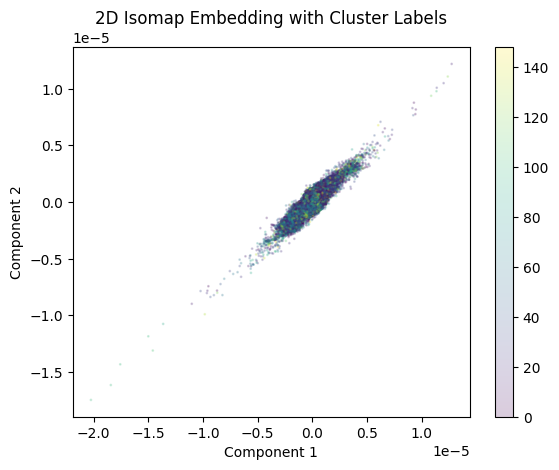

In [ ]:
# plot
import matplotlib.pyplot as plt

plt.scatter(transformed_embeddings[0], transformed_embeddings[1], c=cluster_labels, cmap='viridis', s=1, alpha=0.2)
plt.colorbar()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D Isomap Embedding with Cluster Labels')
plt.show()

In [ ]:
# save to h5
tsne_embeddings = pd.DataFrame(transformed_embeddings)
tsne_embeddings.to_hdf('tsne_embeddings_3.h5', key='tsne_embeddings', mode='w', format='table')

In [ ]:
cluster_labels = pd.DataFrame(cluster_labels)
cluster_labels.to_hdf('clusters_3.h5', key='clusters', mode='w', format='table')